In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastbook import *

In [3]:
import cv2
import os

In [4]:
root_dir = "../data/usq/"

In [5]:
def create_MIP(np_img, slices_num = 15):
    ''' create the mip image from original image, slice_num is the number of 
    slices for maximum intensity projection'''
    img_shape = np_img.shape
    np_mip = np.zeros(img_shape)
    for i in range(img_shape[0]):
        start = max(0, i-slices_num)
        np_mip[i,:,:] = np.amax(np_img[start:i+1],0)
    return np_mip

In [6]:
def save_images(img_dir, file_list, img_3d_array):
    for i in range(img_3d_array.shape[0]):
        cv2.imwrite(os.path.join(img_dir, file_list[i]), img_3d_array[i, :, :])

In [5]:
def load_images (img_dir, file_list, d, h, w): 
    limg = np.ndarray(shape=(d, h, w), dtype=np.uint16)
    i=0
    for f in file_list: 
        img = cv2.imread(os.path.join(img_dir, f))
        # convert image to grey 
        #img = convert_image_to_grey(img,h,w)
        # not needed
        #grey_img = np.zeros((h,w), np.uint16)
        #grey_img[:h,:w] = img[:,:,0] 
        #limg[i]=grey_img
        limg[i]=img[:,:,0] 
        i=i+1
    return limg 

In [6]:
def convert_3d_mip(parent_dir, omit, source_dir = 'original_mra', target_dir = 'mra_mip'):
    #do images
    for subdir in os.listdir(os.path.join(parent_dir, source_dir)):
        # leave out MRI for test
        if subdir in omit:
            continue
        full_img_subdir = os.path.join(parent_dir, source_dir, subdir)
        fnames = os.listdir(full_img_subdir)
        img_3d = load_images(full_img_subdir, fnames, len(fnames), 320, 320)
        img_mip = create_MIP(img_3d, slices_num = img_3d.shape[0])
        # create target dir
        tgt_dir =  os.path.join(parent_dir, target_dir, subdir)
        os.makedirs(tgt_dir, exist_ok=True)
        save_images(tgt_dir, fnames, img_mip)    

In [12]:
def combine(parent_dir, image_src, image_tgt, mask_src, mask_tgt):
    image_srcdir = os.path.join(parent_dir, image_src)
    mask_srcdir = os.path.join(parent_dir, mask_src)
    image_tgtdir = os.path.join(parent_dir, image_tgt)
    mask_tgtdir = os.path.join(parent_dir, mask_tgt)  
    
    os.makedirs(image_tgtdir, exist_ok=True)
    os.makedirs(mask_tgtdir, exist_ok=True)
    
    for subdir in os.scandir(image_srcdir):
        image_list = sorted(os.listdir(subdir))
        mask_list = sorted(os.listdir(os.path.join(mask_srcdir, os.path.basename(subdir))))
        for i in range(len(image_list)):
            if image_list[i].endswith('.jpg'):
                shutil.copy(os.path.join(subdir.path, image_list[i]), os.path.join(image_tgtdir, image_list[i])) 
                shutil.copy(os.path.join(os.path.join(mask_srcdir, os.path.basename(subdir)), mask_list[i]), os.path.join(mask_tgtdir, image_list[i]))

In [19]:
# convert_3d_mip(root_dir, 'original_mra', 'mra_mip')
# convert_3d_mip(root_dir, 'manual_segmentation',  'mask_mip')

In [28]:
train_list = ['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663']
test_list = ['MNI_0664']

In [29]:
# do training run
convert_3d_mip(root_dir, test_list, 'original_mra', 'train_mra_mip')
convert_3d_mip(root_dir, test_list, 'manual_segmentation',  'train_mask_mip')

In [30]:
# apply to test set
convert_3d_mip(root_dir, train_list, 'original_mra', 'test_mra_mip')
convert_3d_mip(root_dir, train_list, 'manual_segmentation',  'test_mask_mip')

In [37]:
# put together in train/test folders with consistent naming for image/mask
combine(root_dir, 'train_mra_mip', 'train/images', 'train_mask_mip', 'train/masks')
combine(root_dir, 'test_mra_mip', 'test/images', 'test_mask_mip', 'test/masks')

In [53]:
def combine(parent_dir, image_src, image_tgt, mask_src, mask_tgt, mra):
    image_srcdir = os.path.join(parent_dir, image_src)
    mask_srcdir = os.path.join(parent_dir, mask_src)
    #image_tgtdir = os.path.join(parent_dir, image_tgt, mra, 'images')
    #mask_tgtdir = os.path.join(parent_dir, mask_tgt, mra, 'masks')  
    image_tgtdir = os.path.join(parent_dir, image_tgt)
    mask_tgtdir = os.path.join(parent_dir, mask_tgt)
    os.makedirs(image_tgtdir, exist_ok=True)
    os.makedirs(mask_tgtdir, exist_ok=True)
    image_list = sorted(os.listdir(os.path.join(image_srcdir, mra)))
    mask_list = sorted(os.listdir(os.path.join(mask_srcdir, os.path.basename(mra))))
    for i in range(len(image_list)):
        if image_list[i].endswith('.jpg'):
            print(f'copying {os.path.join(image_srcdir, mra, image_list[i])} to {os.path.join(image_tgtdir, image_list[i])}')

            shutil.copy(os.path.join(image_srcdir, mra, image_list[i]), os.path.join(image_tgtdir, image_list[i])) 
            shutil.copy(os.path.join(os.path.join(mask_srcdir, os.path.basename(mra)), mask_list[i]), os.path.join(mask_tgtdir, image_list[i]))

In [54]:
# one off

In [55]:
# run for individual
test_list = ['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663']
for i in test_list:
    combine(root_dir, 'train_mra_mip', f'oneoff/{i}/images', 'train_mask_mip', f'oneoff/{i}/masks', i)

copying ../data/usq/train_mra_mip/MNI_0590/S580900000.jpg to ../data/usq/oneoff/MNI_0590/images/S580900000.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900001.jpg to ../data/usq/oneoff/MNI_0590/images/S580900001.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900002.jpg to ../data/usq/oneoff/MNI_0590/images/S580900002.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900003.jpg to ../data/usq/oneoff/MNI_0590/images/S580900003.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900004.jpg to ../data/usq/oneoff/MNI_0590/images/S580900004.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900005.jpg to ../data/usq/oneoff/MNI_0590/images/S580900005.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900006.jpg to ../data/usq/oneoff/MNI_0590/images/S580900006.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900007.jpg to ../data/usq/oneoff/MNI_0590/images/S580900007.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900008.jpg to ../data/usq/oneoff/MNI_0590/images/S580900008.jpg
c

copying ../data/usq/train_mra_mip/MNI_0591/S580960181.jpg to ../data/usq/oneoff/MNI_0591/images/S580960181.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960182.jpg to ../data/usq/oneoff/MNI_0591/images/S580960182.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960183.jpg to ../data/usq/oneoff/MNI_0591/images/S580960183.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960184.jpg to ../data/usq/oneoff/MNI_0591/images/S580960184.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960185.jpg to ../data/usq/oneoff/MNI_0591/images/S580960185.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960186.jpg to ../data/usq/oneoff/MNI_0591/images/S580960186.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960187.jpg to ../data/usq/oneoff/MNI_0591/images/S580960187.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960188.jpg to ../data/usq/oneoff/MNI_0591/images/S580960188.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960189.jpg to ../data/usq/oneoff/MNI_0591/images/S580960189.jpg
c

copying ../data/usq/train_mra_mip/MNI_0640/S572920117.jpg to ../data/usq/oneoff/MNI_0640/images/S572920117.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920118.jpg to ../data/usq/oneoff/MNI_0640/images/S572920118.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920119.jpg to ../data/usq/oneoff/MNI_0640/images/S572920119.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920120.jpg to ../data/usq/oneoff/MNI_0640/images/S572920120.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920121.jpg to ../data/usq/oneoff/MNI_0640/images/S572920121.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920122.jpg to ../data/usq/oneoff/MNI_0640/images/S572920122.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920123.jpg to ../data/usq/oneoff/MNI_0640/images/S572920123.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920124.jpg to ../data/usq/oneoff/MNI_0640/images/S572920124.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920125.jpg to ../data/usq/oneoff/MNI_0640/images/S572920125.jpg
c

copying ../data/usq/train_mra_mip/MNI_0648/S574110075.jpg to ../data/usq/oneoff/MNI_0648/images/S574110075.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110076.jpg to ../data/usq/oneoff/MNI_0648/images/S574110076.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110077.jpg to ../data/usq/oneoff/MNI_0648/images/S574110077.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110078.jpg to ../data/usq/oneoff/MNI_0648/images/S574110078.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110079.jpg to ../data/usq/oneoff/MNI_0648/images/S574110079.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110080.jpg to ../data/usq/oneoff/MNI_0648/images/S574110080.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110081.jpg to ../data/usq/oneoff/MNI_0648/images/S574110081.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110082.jpg to ../data/usq/oneoff/MNI_0648/images/S574110082.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110083.jpg to ../data/usq/oneoff/MNI_0648/images/S574110083.jpg
c

copying ../data/usq/train_mra_mip/MNI_0657/S571730031.jpg to ../data/usq/oneoff/MNI_0657/images/S571730031.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730032.jpg to ../data/usq/oneoff/MNI_0657/images/S571730032.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730033.jpg to ../data/usq/oneoff/MNI_0657/images/S571730033.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730034.jpg to ../data/usq/oneoff/MNI_0657/images/S571730034.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730035.jpg to ../data/usq/oneoff/MNI_0657/images/S571730035.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730036.jpg to ../data/usq/oneoff/MNI_0657/images/S571730036.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730037.jpg to ../data/usq/oneoff/MNI_0657/images/S571730037.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730038.jpg to ../data/usq/oneoff/MNI_0657/images/S571730038.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730039.jpg to ../data/usq/oneoff/MNI_0657/images/S571730039.jpg
c

copying ../data/usq/train_mra_mip/MNI_0663/S572080186.jpg to ../data/usq/oneoff/MNI_0663/images/S572080186.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080187.jpg to ../data/usq/oneoff/MNI_0663/images/S572080187.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080188.jpg to ../data/usq/oneoff/MNI_0663/images/S572080188.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080189.jpg to ../data/usq/oneoff/MNI_0663/images/S572080189.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080190.jpg to ../data/usq/oneoff/MNI_0663/images/S572080190.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080191.jpg to ../data/usq/oneoff/MNI_0663/images/S572080191.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080192.jpg to ../data/usq/oneoff/MNI_0663/images/S572080192.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080193.jpg to ../data/usq/oneoff/MNI_0663/images/S572080193.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080194.jpg to ../data/usq/oneoff/MNI_0663/images/S572080194.jpg
c

In [56]:
# run for individual
test_list = ['MNI_0664']
for i in test_list:
    combine(root_dir, 'test_mra_mip', f'oneoff/{i}/images', 'test_mask_mip', f'oneoff/{i}/masks', i)

copying ../data/usq/test_mra_mip/MNI_0664/S569380000.jpg to ../data/usq/oneoff/MNI_0664/images/S569380000.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380001.jpg to ../data/usq/oneoff/MNI_0664/images/S569380001.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380002.jpg to ../data/usq/oneoff/MNI_0664/images/S569380002.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380003.jpg to ../data/usq/oneoff/MNI_0664/images/S569380003.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380004.jpg to ../data/usq/oneoff/MNI_0664/images/S569380004.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380005.jpg to ../data/usq/oneoff/MNI_0664/images/S569380005.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380006.jpg to ../data/usq/oneoff/MNI_0664/images/S569380006.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380007.jpg to ../data/usq/oneoff/MNI_0664/images/S569380007.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380008.jpg to ../data/usq/oneoff/MNI_0664/images/S569380008.jpg
copying ..

copying ../data/usq/test_mra_mip/MNI_0664/S569380100.jpg to ../data/usq/oneoff/MNI_0664/images/S569380100.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380101.jpg to ../data/usq/oneoff/MNI_0664/images/S569380101.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380102.jpg to ../data/usq/oneoff/MNI_0664/images/S569380102.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380103.jpg to ../data/usq/oneoff/MNI_0664/images/S569380103.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380104.jpg to ../data/usq/oneoff/MNI_0664/images/S569380104.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380105.jpg to ../data/usq/oneoff/MNI_0664/images/S569380105.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380106.jpg to ../data/usq/oneoff/MNI_0664/images/S569380106.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380107.jpg to ../data/usq/oneoff/MNI_0664/images/S569380107.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380108.jpg to ../data/usq/oneoff/MNI_0664/images/S569380108.jpg
copying ..

copying ../data/usq/test_mra_mip/MNI_0664/S569380202.jpg to ../data/usq/oneoff/MNI_0664/images/S569380202.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380203.jpg to ../data/usq/oneoff/MNI_0664/images/S569380203.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380204.jpg to ../data/usq/oneoff/MNI_0664/images/S569380204.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380205.jpg to ../data/usq/oneoff/MNI_0664/images/S569380205.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380206.jpg to ../data/usq/oneoff/MNI_0664/images/S569380206.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380207.jpg to ../data/usq/oneoff/MNI_0664/images/S569380207.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380208.jpg to ../data/usq/oneoff/MNI_0664/images/S569380208.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380209.jpg to ../data/usq/oneoff/MNI_0664/images/S569380209.jpg
copying ../data/usq/test_mra_mip/MNI_0664/S569380210.jpg to ../data/usq/oneoff/MNI_0664/images/S569380210.jpg
copying ..

In [2]:
import numpy as np

I = [[1,0,0],
     [0,1,0],
     [0,0,1]]

In [3]:
from math import sin, cos, radians

theta = radians(30)
c, s = cos(theta), sin(theta)
RY = np.array([[c, 0, s],[0, 1, 0], [-s, 0, c]])
# at this point I'd be dotting the Identiy matrix, but I'll include for completeness
I_RY = np.dot(I, RY)

In [4]:
I_RY

array([[ 0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       ,  0.8660254]])

In [48]:
def create_gif(filenames, duration):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration=duration)

In [49]:
def create_mipGIF_from_3D(img,nb_image=40,duration=0.1,is_mask=False,borne_max=None):
    ls_mip=[]

    img_data=img.get_data()
    img_data+=1e-5
    
    for angle in np.linspace(0,360,nb_image):
        ls_slice=[]
        vol_angle= scipy.ndimage.interpolation.rotate(img_data,angle)
        
        MIP=np.amax(vol_angle,axis=1)
        MIP-=1e-5
        MIP[MIP<1e-5]=0
        MIP=np.flipud(MIP.T)
        ls_mip.append(MIP)
    try:
        shutil.rmtree('test_gif/')
    except:
        pass
    os.mkdir('test_gif/')

    ls_image=[]
    for mip,i in zip(ls_mip,range(len(ls_mip))):
        fig,ax=plt.subplots()
        ax.set_axis_off()
        if borne_max is None:
            if is_mask==True:
                borne_max=1
            else:
                borne_max=15000
        plt.imshow(mip,cmap='Greys',vmax=borne_max)
        fig.savefig('test_gif/MIP'+'%04d' % (i)+'.png')
        plt.close(fig)

    filenames=glob.glob('test_gif/*.png')

    create_gif(filenames, duration)
    try:
        shutil.rmtree('test_gif/')
    except:
        pass

In [44]:
# make image projections
import numpy as np
import SimpleITK as sitk

def make_mips(image_path, output_dir):
    image = sitk.GetImageFromArray(image_path)
    image_size = image.GetSize()

    basename = os.path.basename(output_dir)
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    for dim in range(3):
        projection = sitk.MaximumProjection(image, dim)

        if image_size[dim] % 2:  # odd number
            voxel = [0, 0, 0]
            voxel[dim] = (image_size[dim] - 1) / 2
            origin = image.TransformIndexToPhysicalPoint(voxel)
        else:  # even
            voxel1 = np.array([0, 0, 0], int)
            voxel2 = np.array([0, 0, 0], int)
            voxel1[dim] = image_size[dim] / 2 - 1
            voxel2[dim] = image_size[dim] / 2
            point1 = np.array(image.TransformIndexToPhysicalPoint(voxel1.tolist()))
            point2 = np.array(image.TransformIndexToPhysicalPoint(voxel2.tolist()))
            origin = np.mean(np.vstack((point1, point2)), 0)
        projection.SetOrigin(origin)
        projection.SetDirection(image.GetDirection())
        proj_basename = os.path.join(basename, f'{dim}.jpg')
        sitk.WriteImage(projection, os.path.join(output_dir, proj_basename))

In [45]:
def load_images (img_dir, file_list, d, h, w): 
    limg = np.ndarray(shape=(d, h, w), dtype=np.uint16)
    i=0
    for f in file_list:
        img = cv2.imread(os.path.join(img_dir, f))
        limg[i]=img[:,:,0] 
        i=i+1
    return limg 

In [46]:
def convert_3d_mip(parent_dir, omit, source_dir = 'original_mra', target_dir = 'mra_mip'):
    #do images
    for subdir in os.listdir(os.path.join(parent_dir, source_dir)):
        # leave out MRI for test
        if subdir in omit:
            continue
        full_img_subdir = os.path.join(parent_dir, source_dir, subdir)
        #print(f'full {full_img_subdir}')
        fnames = os.listdir(full_img_subdir)
        img_3d = load_images(full_img_subdir, fnames, len(fnames), 320, 320)
        tgt_dir =  os.path.join(parent_dir, target_dir, subdir)
        print(tgt_dir)
        os.makedirs(tgt_dir, exist_ok=True)
        img_mip = make_mips(img_3d, tgt_dir)
        # create target dir

In [42]:
train_list = ['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663']
test_list = ['MNI_0664']

In [47]:
root_dir = "../data/usq/"
convert_3d_mip(root_dir, train_list, 'tst_orig_ip', 'tst_orig_ip_complete')

../data/usq/tst_orig_ip_complete/MNI_0664


RuntimeError: Exception thrown in SimpleITK ImageFileWriter_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/JPEG/src/itkJPEGImageIO.cxx:389:
ITK ERROR: JPEGImageIO(0x5610911a7170): JPEG Writer can only write 2-dimensional images

In [50]:
fnames = os.listdir('../data/usq/tst_orig_ip/MNI_0590')
img_3d = load_images('../data/usq/tst_orig_ip/MNI_0590', fnames, len(fnames), 320, 320)

In [58]:
img_3d.shape

(247, 320, 320)

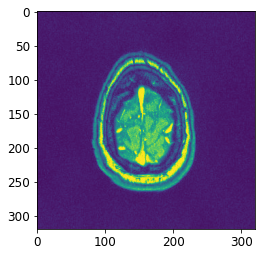

In [57]:
plt.imshow(img_3d[246, :, :])

In [59]:
m1 = np.rot90(img_3d, axes=(0,1))
m2 = np.rot90(img_3d, axes=(1,2))
m3 = np.rot90(img_3d, axes=(0,2))

In [60]:
m1.shape

(320, 247, 320)

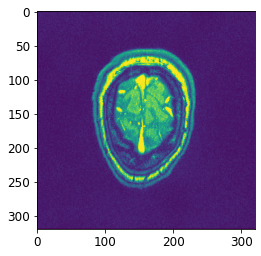

In [62]:
plt.imshow(m1[:, 246, :])

In [64]:
m2.shape

(247, 320, 320)

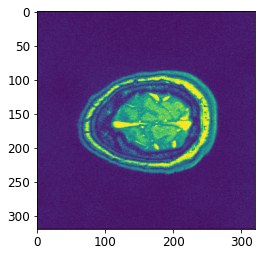

In [65]:
plt.imshow(m2[246, :, :])

In [66]:
m3.shape

(320, 320, 247)

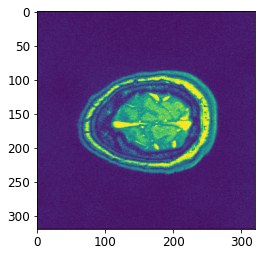

In [67]:
plt.imshow(m3[:, :, 246])

NameError: name 'img_shape' is not defined

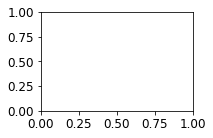

In [68]:
# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img_3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img_3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img_3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()